In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import scipy.integrate as integ
from scipy.optimize import curve_fit
import simulation_utility as su
import time
import json
import os

Number of waveforms 10005, time to read 7.87


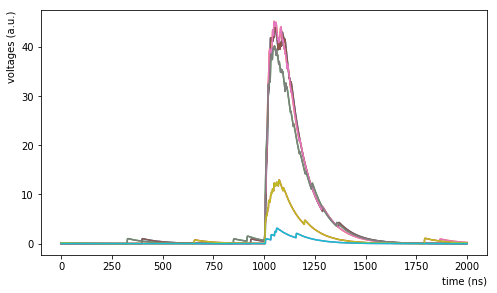

In [2]:
wfs1 = su.read_waveforms_from_json(PE = 1, plot = True)

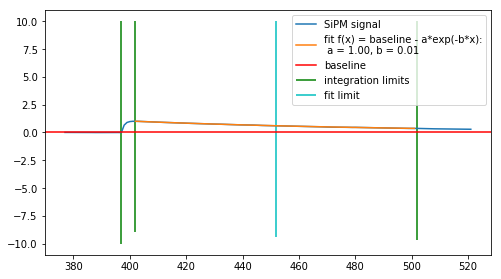

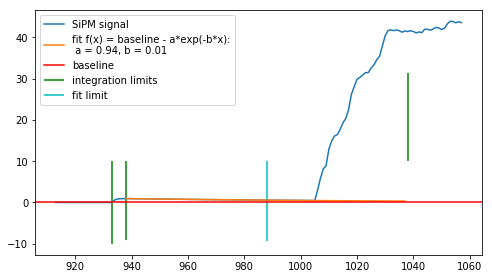

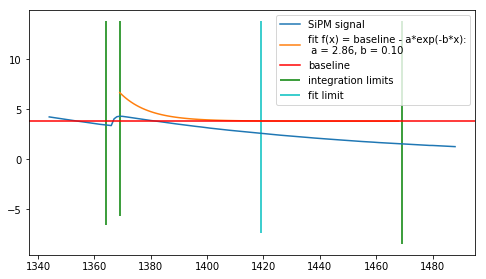

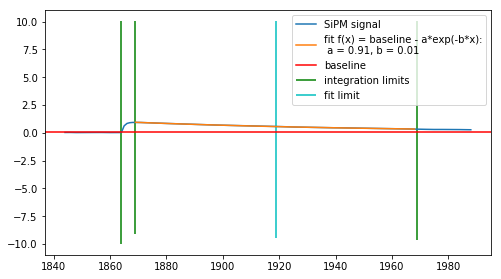

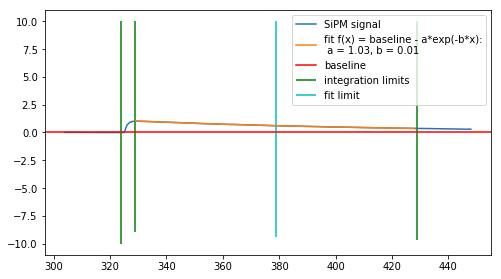

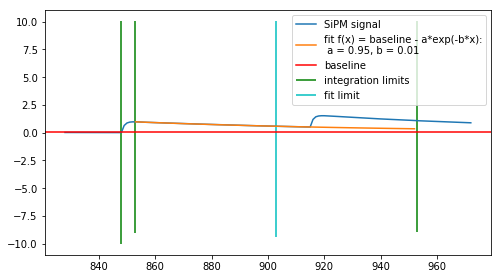

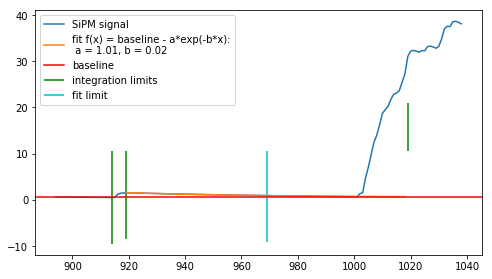

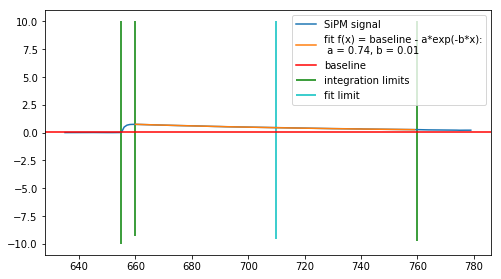

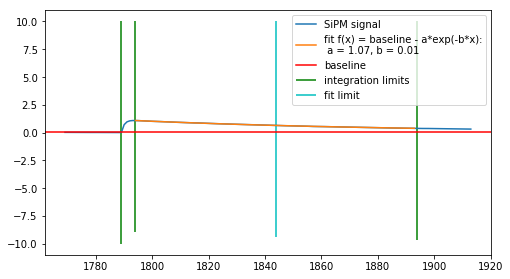

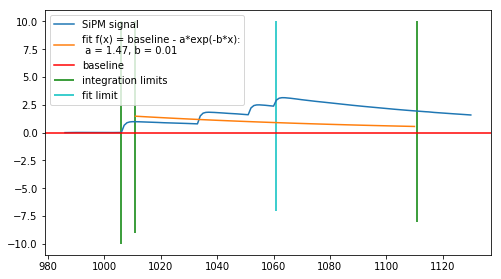

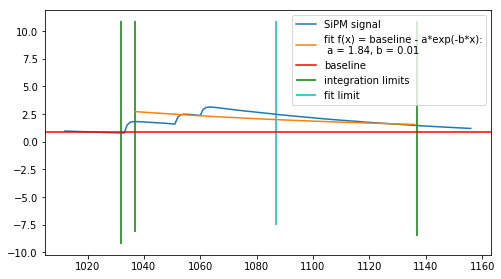

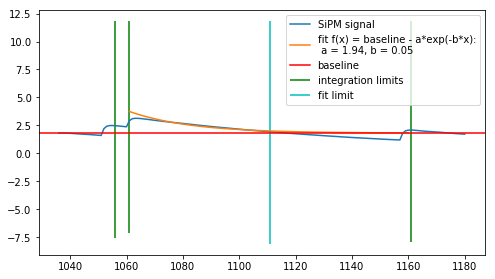

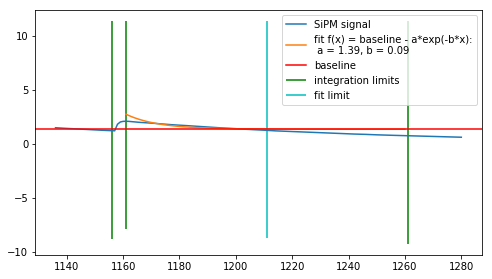

In [3]:
for i in range(5):
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

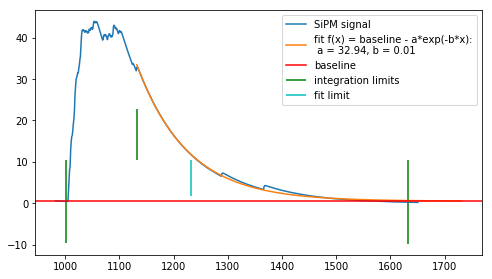

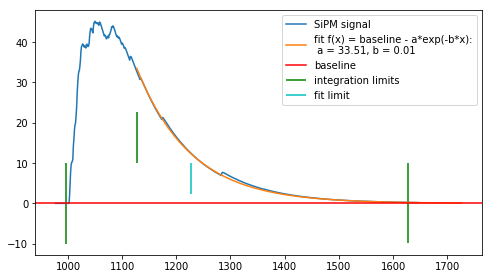

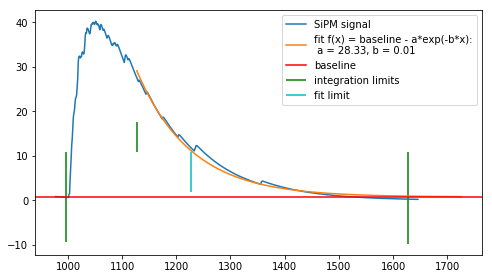

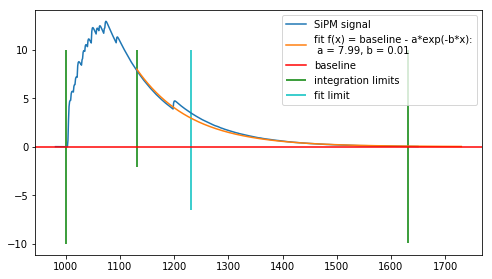

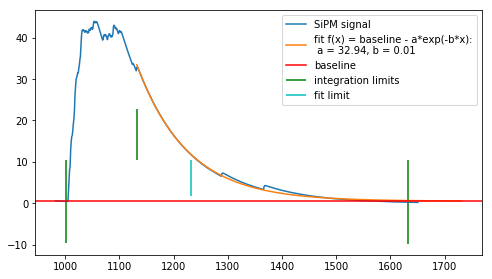

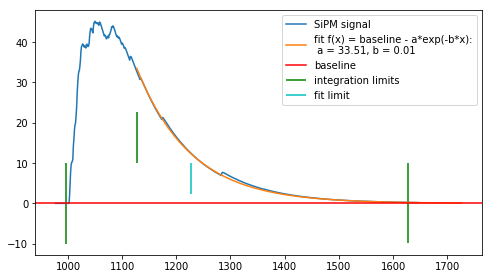

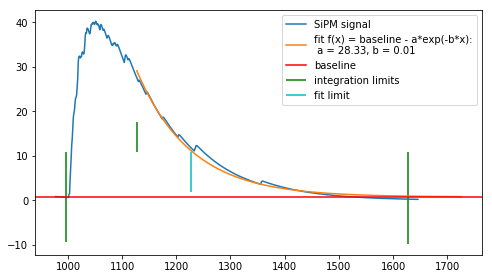

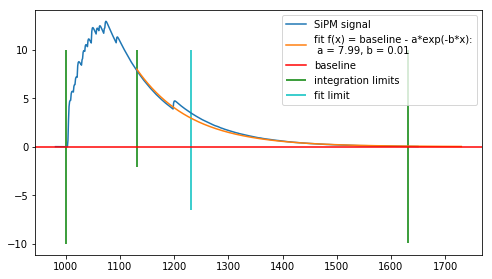

In [4]:
for i in range(10):
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-30,100,200,600,15,8,10,plot=1)

In [5]:
def calculate_integrals(wfs,PE=1,angle=0):
    integrals = []
    t_start = time.time()
    for i in range(len(wfs)):
        listpeaks = su.search_peaks(wfs[i],5,0.5,plot=False)
        #ints = su.integral_simulation_peaks(wfs[i],listpeaks,-5,0,50,100,5,8,10,plot=0,central=0)
        #integrals.append(ints)
        ints = su.integral_simulation_peaks(wfs[i],listpeaks,-30,100,200,600,15,8,10,plot=0,central=1)
        integrals.append(ints)
        diff = time.time() - t_start
        if (i % 1000) == 0:
            print(f'event n. {i} time to process: {diff:.2f}')
    integrals = np.concatenate(integrals)
    np.save(f'integrals/integrals_PE{PE}_angle{angle}.npy',integrals)
    return integrals

In [6]:
integrals = calculate_integrals(wfs1,PE=1,angle=0)

event n. 0 time to process: 0.01
event n. 1000 time to process: 6.14
event n. 2000 time to process: 12.19
event n. 3000 time to process: 18.16
event n. 4000 time to process: 23.95
event n. 5000 time to process: 29.72
event n. 6000 time to process: 35.56
event n. 7000 time to process: 41.45
event n. 8000 time to process: 47.31
event n. 9000 time to process: 53.57
event n. 10000 time to process: 59.50


# Simulation with 2PE

Number of waveforms 10005, time to read 7.94


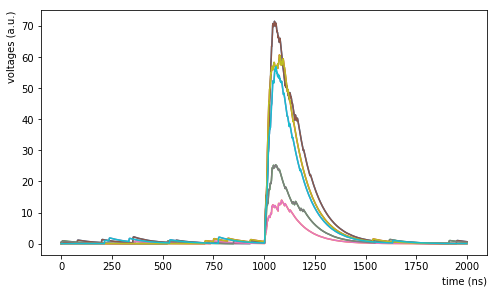

In [7]:
wfs2 = su.read_waveforms_from_json(PE = 2, plot = True)

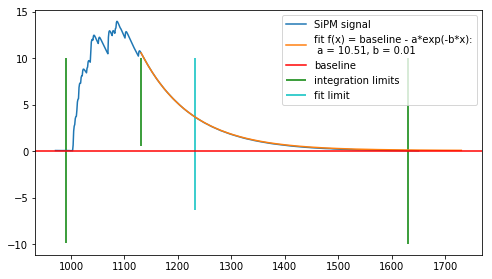

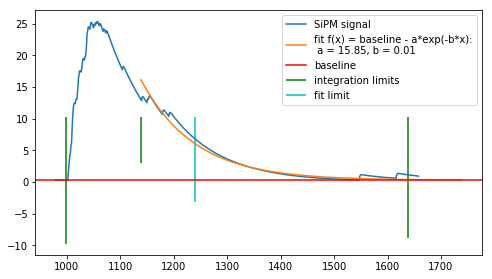

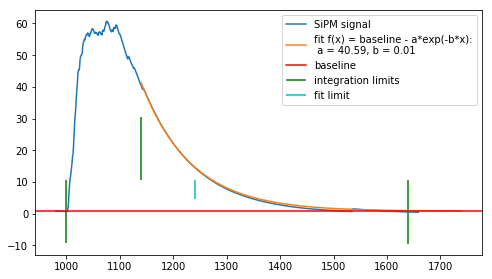

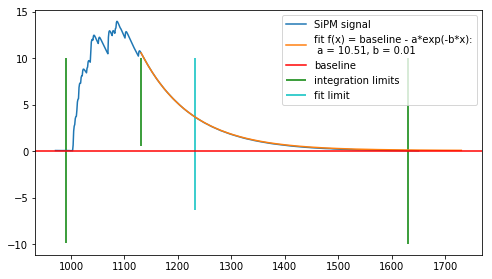

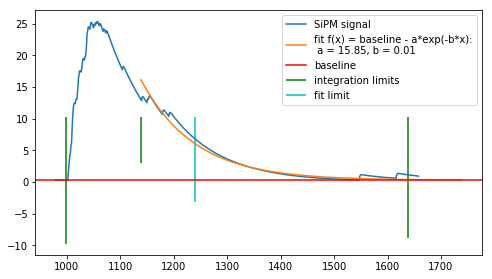

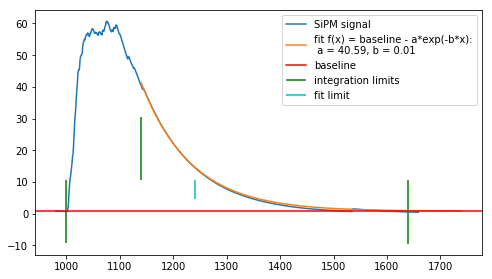

In [8]:
for i in range(10):
    listpeaks = su.search_peaks(wfs2[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs2[i],listpeaks,-40,100,200,600,15,8,10,plot=1)

In [9]:
integrals2 = calculate_integrals(wfs2,PE=2,angle=0)

event n. 0 time to process: 0.00
event n. 1000 time to process: 5.47
event n. 2000 time to process: 11.33
event n. 3000 time to process: 17.07
event n. 4000 time to process: 22.73
event n. 5000 time to process: 28.16
event n. 6000 time to process: 33.85
event n. 7000 time to process: 39.60
event n. 8000 time to process: 45.16
event n. 9000 time to process: 50.72
event n. 10000 time to process: 56.28


# Simulation with 3PE

Number of waveforms 10005, time to read 7.90


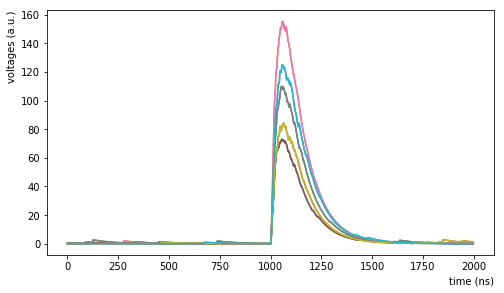

In [10]:
wfs3 = su.read_waveforms_from_json(PE = 3, plot = True)

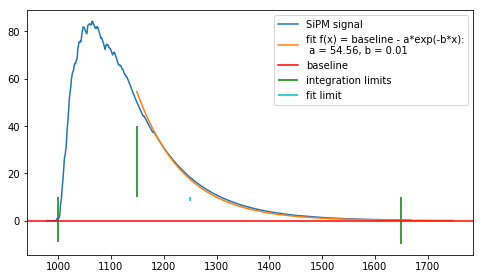

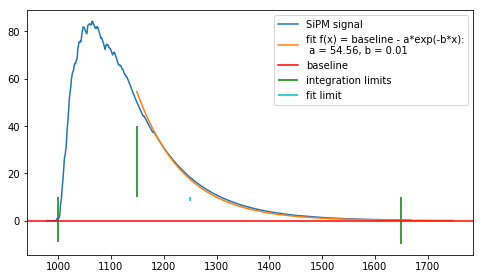

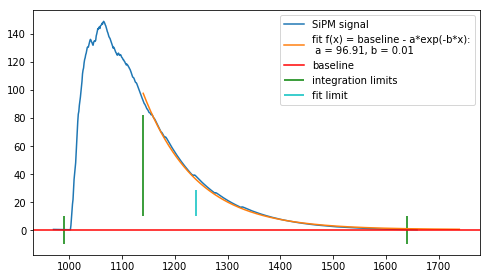

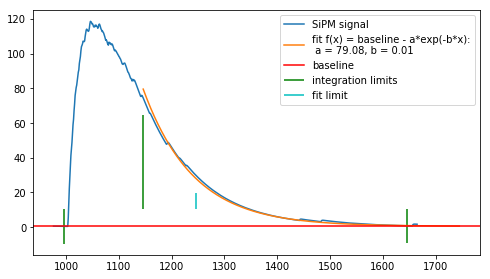

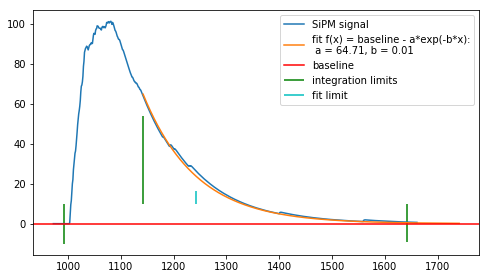

In [11]:
for i in range(20):
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-50,100,200,600,15,8,10,plot=1)

In [12]:
integrals3 = calculate_integrals(wfs3, PE = 3, angle = 0)

event n. 0 time to process: 0.00
event n. 1000 time to process: 4.63
event n. 2000 time to process: 9.18
event n. 3000 time to process: 13.65
event n. 4000 time to process: 18.28
event n. 5000 time to process: 22.88
event n. 6000 time to process: 27.62
event n. 7000 time to process: 32.05
event n. 8000 time to process: 36.53
event n. 9000 time to process: 41.33
event n. 10000 time to process: 45.92


n. events: 1PE=7264, 2PE=6514, 3PE=4849


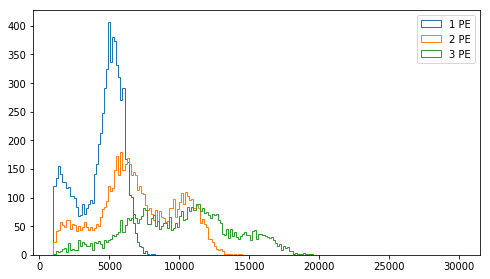

In [13]:
plt.figure(figsize=(8,4.5))
integrals = np.load(f'integrals/integrals_PE1_angle0.npy')
integrals2 = np.load(f'integrals/integrals_PE2_angle0.npy')
integrals3 = np.load(f'integrals/integrals_PE3_angle0.npy')
print(f'n. events: 1PE={len(integrals)}, 2PE={len(integrals2)}, 3PE={len(integrals3)}')
a = plt.hist(integrals,bins=200,range=(1000,30000),density=0,histtype='step',label=f'1 PE')
a = plt.hist(integrals2,bins=200,range=(1000,30000),density=0,histtype='step',label='2 PE')
a = plt.hist(integrals3,bins=200,range=(1000,30000),density=0,histtype='step',label='3 PE')
#plt.yscale('log')
plt.legend()

In [14]:
def simple_integral_central_peak( wfs, dtl = 100, dtr = 100, plot=False):
    integrals = []
    for i in range(len(wfs)):
        wf = wfs[i]
        tt = np.array([i for i in range(len(wf))])
        amp = np.max(wf) #local amplitude of the signal
        tmax = tt[wf == amp][0]
        tl = tt[(tt <= tmax+dtr) & (tt >= tmax-dtl)]
        wfl = wf[(tt <= tmax+dtr) & (tt >= tmax-dtl)]
        integral = integ.simps(wfl, tl)
        integrals.append(integral)
        if plot:
            plt.figure(figsize=(8,4.5))
            tplot = tt[tmax-dtl-20:tmax+dtr+20]
            plt.plot(tplot,wf[tmax-dtl-20:tmax+dtr+20],label=f'SiPM signal: A = {integral:.1f}')
            plt.vlines((tmax-dtl), 10, 0, colors = 'g',
                       label = 'integration limits')
            plt.vlines((tmax+dtr), 10, 0, colors = 'g')
            plt.axhline(0, color = 'r')
            plt.legend()
        
    #np.save(f'integrals/integrals_PE{PE}_angle{angle}.npy',integrals)
    return integrals

In [15]:
realint1 = simple_integral_central_peak( wfs1, 70, 600)   
realint2 = simple_integral_central_peak( wfs2, 70, 600)  
realint3 = simple_integral_central_peak( wfs3, 70, 600)

n. events: 1PE=10005, 2PE=10005, 3PE=10005


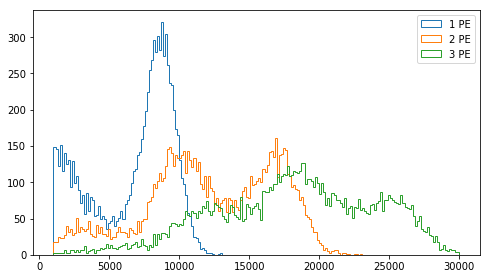

In [16]:
plt.figure(figsize=(8,4.5))
print(f'n. events: 1PE={len(realint1)}, 2PE={len(realint2)}, 3PE={len(realint3)}')
a = plt.hist(realint1,bins=200,range=(1000,30000),density=0,histtype='step',label='1 PE')
a = plt.hist(realint2,bins=200,range=(1000,30000),density=0,histtype='step',label='2 PE')
a = plt.hist(realint3,bins=200,range=(1000,30000),density=0,histtype='step',label='3 PE')
#plt.yscale('log')
plt.legend()